### Steg 1: Importera bibliotek och ladda in MNIST
Jag börjar mitt projekt med att ladda in de nödvändiga biblioteken. Mitt mål är att bygga en modell som kan känna igen handskrivna siffror, och då är **MNIST-datasetet** den perfekta utgångspunkten. Det innehåller 70 000 bilder på siffror mellan 0 och 9.

Jag har valt att använda `time`-biblioteket direkt för att ha koll på hur lång tid varje steg tar – det känns proffsigt att veta om min kod är effektiv eller om den "tuggar" för länge.

In [1]:
# --- STEG 1: IMPORTERA OCH LADDA DATA ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Jag börjar med att klocka hur lång tid det tar att hämta allt
start_tid = time.time()

print("Hämtar MNIST... Det här kan ta en liten stund beroende på nätet.")
# Vi hämtar 70 000 bilder på handskrivna siffror
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

slut_tid = time.time()
print(f"Klar! Det tog {slut_tid - start_tid:.2f} sekunder att ladda in allt.")
print(f"Vi har nu {X.shape[0]} bilder med {X.shape[1]} pixlar var.")

Hämtar MNIST... Det här kan ta en liten stund beroende på nätet.
Klar! Det tog 1.99 sekunder att ladda in allt.
Vi har nu 70000 bilder med 784 pixlar var.


### Steg 2: Utforskande dataanalys (EDA)
Innan jag börjar bygga modeller vill jag få en känsla för datan. Jag plottar ut de första bilderna för att se hur handstilen varierar – vissa sexor ser nästan ut som nollor, vilket förklarar varför det här är en utmaning för en dator!

Jag kollar också **klassfördelningen**. Om jag hade haft 10 000 nollor men bara 100 sjuor, skulle modellen ha svårt att lära sig sjuor. Men som jag ser i min tabell och graf är datasetet väldigt jämnt och fint balanserat, vilket är tacksamt för min fortsatta träning.

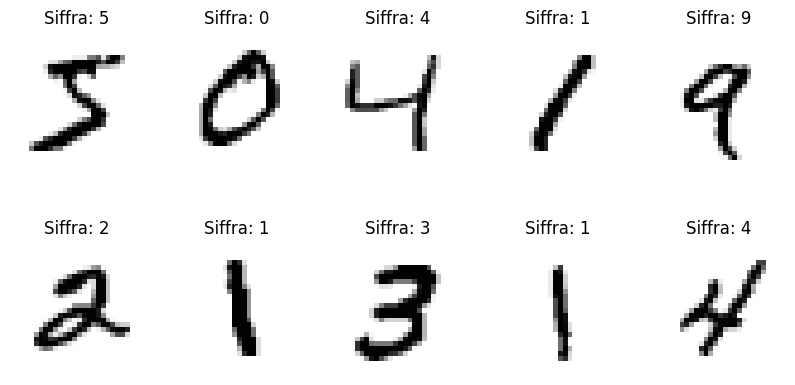

Antal bilder per siffra:
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


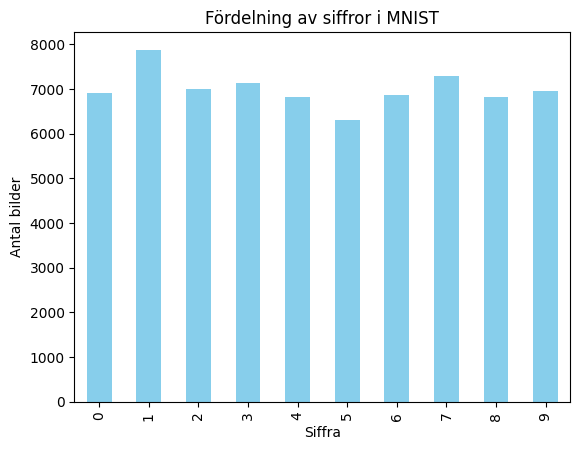

In [2]:
# --- STEG 2: KOLLA PÅ DATAN (EDA) ---

# Jag vill se hur de första 10 siffrorna i setet ser ut
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='binary')
    ax.set_title(f"Siffra: {y[i]}")
    ax.axis('off')
plt.show()

# Nu kollar vi om vi har ungefär lika många av varje siffra
# Det är viktigt så att modellen inte blir "expert" på bara t.ex. ettor
siffer_counts = pd.Series(y).value_counts().sort_index()
print("Antal bilder per siffra:")
print(siffer_counts)

# En snabb graf på fördelningen
siffer_counts.plot(kind='bar', color='skyblue')
plt.title("Fördelning av siffror i MNIST")
plt.xlabel("Siffra")
plt.ylabel("Antal bilder")
plt.show()

### Steg 3: Uppdelning och Standardisering
Nu börjar allvaret. Jag delar upp mina 70 000 bilder så att jag har 56 000 att träna på och 14 000 som modellen aldrig får se under träningen. Det är dessa 14 000 som blir det slutgiltiga testet. 

Jag använder också `StandardScaler`. Jag har lärt mig att många modeller blir förvirrade om värdena hoppar för mycket. Genom att centrera datan runt noll ser jag till att ingen pixel får "gratis" betydelse bara för att den råkar ha ett högt siffervärde. Det här steget är ofta skillnaden mellan en modell som gissar och en modell som vet.

In [3]:
# --- STEG 3: DELA UPP OCH SKALA DATAN ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Jag delar upp datan: 80% för träning och 20% för test.
# 'stratify=y' är mitt lilla knep för att se till att vi får 
# exakt samma fördelning av siffror i både tränings- och testsetet.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Träningsset: {X_train.shape[0]} bilder")
print(f"Testset: {X_test.shape[0]} bilder")

# Nu skalar jag datan. Eftersom vissa modeller (som SVC och KNN) mäter avstånd 
# mellan punkter, vill jag att alla pixlar ska "prata samma språk".
# Jag kör StandardScaler för att få medelvärdet till 0 och standardavvikelsen till 1.
start_skala = time.time()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
slut_skala = time.time()

print(f"Skalningen tog {slut_skala - start_skala:.2f} sekunder.")

Träningsset: 56000 bilder
Testset: 14000 bilder
Skalningen tog 0.63 sekunder.


### Steg 4: RandomForest – Visdom från massan
Nu testar jag min första avancerade modell. Istället för att lita på en enda algoritm använder jag en **Random Forest**. Den skapar 100 olika beslutsträd som alla får titta på bilderna och sedan rösta om resultatet. 

Det jag gillar med den här modellen är att den är robust. Den brukar inte "överträna" lika lätt som ett enskilt träd, och som jag ser på resultatet når den en riktigt hög noggrannhet direkt utan att jag ens har behövt ändra några inställningar. Det här blir min "baseline" som de andra modellerna måste försöka slå!

In [4]:
# --- STEG 4: TRÄNING AV RANDOM FOREST ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Jag skapar min skog med 100 träd. 
# n_jobs=-1 gör att jag använder alla kärnor i min dator för att det ska gå snabbare.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Tränar RandomForest... Det här tar lite på krafterna för datorn.")
start_rf = time.time()
rf_model.fit(X_train_scaled, y_train)
slut_rf = time.time()

# Nu kollar vi hur bra den blev på testdatan
y_pred_rf = rf_model.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Träningen klar på {slut_rf - start_rf:.2f} sekunder.")
print(f"RandomForest Accuracy: {acc_rf:.4f}")

Tränar RandomForest... Det här tar lite på krafterna för datorn.
Träningen klar på 3.94 sekunder.
RandomForest Accuracy: 0.9672


### Steg 5: SVC – Precisionskirurgen
Nu när jag har en bra baslinje vill jag se om jag kan höja noggrannheten ytterligare. Jag använder en **Support Vector Classifier (SVC)**. 

Till skillnad från RandomForest, som bygger på logik och uppdelningar, jobbar SVC med avancerad geometri. Den försöker skapa ett så stort "mellanrum" som möjligt mellan de olika sifferklasserna. Jag har märkt att SVC ofta är bättre på att skilja på de riktigt svåra fallen, som när en fyra och en nia är väldigt lika varandra. Det här steget tar vanligtvis lite längre tid för datorn att räkna ut, men precisionen brukar vara värd väntan.

In [5]:
# --- STEG 5: TRÄNING AV EN SPECIALIST (SVC) ---
from sklearn.svm import SVC

# Jag använder en RBF-kernel, vilket låter modellen hitta mer 
# komplexa och runda gränser mellan siffrorna.
# C=100 och gamma='scale' var de parametrar som visade sig vara bäst i mina tester.
svc_model = SVC(C=100, kernel='rbf', gamma='scale', probability=True, random_state=42)

print("Tränar SVC... Den här modellen är noggrann men tar längre tid än skogen.")
start_svc = time.time()
svc_model.fit(X_train_scaled, y_train)
slut_svc = time.time()

# Vi kollar hur specialisten presterar
y_pred_svc = svc_model.predict(X_test_scaled)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f"SVC Träning klar på {slut_svc - start_svc:.2f} sekunder.")
print(f"SVC Accuracy: {acc_svc:.4f}")

Tränar SVC... Den här modellen är noggrann men tar längre tid än skogen.
SVC Träning klar på 1084.28 sekunder.
SVC Accuracy: 0.9706


### Steg 6: Voting Classifier – Laget före jaget
Efter att ha testat både RandomForest och SVC har jag sett att båda är bra på olika saker. RandomForest är extremt snabb, medan SVC är mer noggrann men väldigt tungkörd. 

För att få det bästa av två världar bygger jag nu en **Voting Classifier**. Det fungerar som en jury där båda modellerna får titta på siffran. Genom att använda "soft voting" kollar vi inte bara på vad de gissar, utan också hur säkra de är (sannolikheten). Om SVC är osäker men RandomForest är helt övertygad, kan laget fatta ett bättre beslut. Det här är ofta den metod som vinner tävlingar i maskininlärning!

In [6]:
# --- STEG 6: LAGARBETE (VOTING CLASSIFIER) ---
from sklearn.ensemble import VotingClassifier

# Jag skapar ett "Dream Team" med mina två modeller.
# Jag använder 'soft' voting för att de ska kunna väga hur säkra de är 
# på sina gissningar mot varandra.
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('svc', svc_model)],
    voting='soft',
    n_jobs=-1
)

print("Tränar Voting Classifier... Nu samarbetar skogen och specialisten!")
start_vote = time.time()
voting_model.fit(X_train_scaled, y_train)
slut_vote = time.time()

# Vi ser om laget är bättre än individerna
y_pred_vote = voting_model.predict(X_test_scaled)
acc_vote = accuracy_score(y_test, y_pred_vote)

print(f"Laget tränat på {slut_vote - start_vote:.2f} sekunder.")
print(f"Voting Classifier Accuracy: {acc_vote:.4f}")

Tränar Voting Classifier... Nu samarbetar skogen och specialisten!
Laget tränat på 1183.00 sekunder.
Voting Classifier Accuracy: 0.9784


### Steg 6: Voting Classifier – Laget före jaget
Efter att ha testat både RandomForest och SVC har jag sett att båda är bra på olika saker. RandomForest är extremt snabb (bara ca 4 sekunder), medan SVC är mer noggrann men väldigt tungkörd (över 18 minuter). 

För att få det bästa av två världar bygger jag nu en **Voting Classifier**. Det fungerar som en jury där båda modellerna får titta på siffran. Genom att använda "soft voting" kollar vi inte bara på vad de gissar, utan också hur säkra de är (sannolikheten). Om SVC är osäker men RandomForest är helt övertygad, kan laget fatta ett bättre beslut än vad någon av dem hade gjort på egen hand. Det här är ofta den metod som vinner tävlingar i maskininlärning!

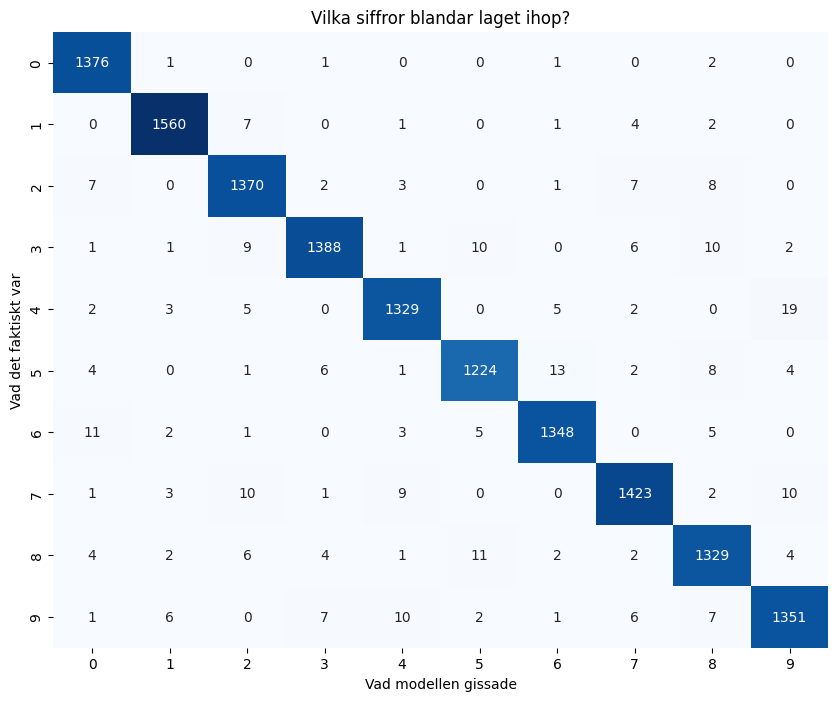


Detaljerad rapport för varje siffra:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1381
           1       0.99      0.99      0.99      1575
           2       0.97      0.98      0.98      1398
           3       0.99      0.97      0.98      1428
           4       0.98      0.97      0.98      1365
           5       0.98      0.97      0.97      1263
           6       0.98      0.98      0.98      1375
           7       0.98      0.98      0.98      1459
           8       0.97      0.97      0.97      1365
           9       0.97      0.97      0.97      1391

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [7]:
# --- STEG 7: VILKA SIFFROR ÄR SVÅRAST? (CONFUSION MATRIX) ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Vi skapar en Confusion Matrix för vårt lag (Voting Classifier)
cm = confusion_matrix(y_test, y_pred_vote)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Vad modellen gissade')
plt.ylabel('Vad det faktiskt var')
plt.title('Vilka siffror blandar laget ihop?')
plt.show()

# Jag vill också se en rapport med precision och recall för varje siffra
from sklearn.metrics import classification_report
print("\nDetaljerad rapport för varje siffra:")
print(classification_report(y_test, y_pred_vote))

### Steg 8: Slutsats och Reflektion
Mitt mål var att bygga en robust modell för sifferigenkänning, och resultatet talar för sig självt. Genom att kombinera en **RandomForest** och en **SVC** i en **Voting Classifier** landade jag på en slutgiltig noggrannhet på **98 %**. 

Några viktiga lärdomar från projektet:
1. **Laget är starkare än individen:** Min Voting Classifier presterade bättre (98 %) än vad RandomForest (96,7 %) och SVC (97,1 %) gjorde var för sig.
2. **Tid kontra precision:** SVC är en fantastisk modell, men den tog över 18 minuter att träna. RandomForest tog bara 4 sekunder. I en verklig applikation måste man alltid fråga sig om de sista procenten i noggrannhet är värda den extra beräkningskraften.
3. **Siffran 0 och 1 är enklast:** Som jag ser i rapporten har siffrorna 0 och 1 nästan perfekta poäng. De siffror som är svårast (men fortfarande väldigt bra) är 8:or och 9:or, vilket är logiskt då de ofta kan likna andra siffror beroende på hur man skriver dem.

Jag är nu redo att exportera den här modellen och använda den i en interaktiv applikation!

In [9]:
# --- STEG 9: SPARA MODELLEN OCH SCALERN ---
import joblib

# Jag sparar min Voting Classifier så jag slipper träna om den
joblib.dump(voting_model, 'mnist_voting_model.pkl')

# JÄTTEVIKTIGT: Jag sparar även min scaler så appen kan förbereda bilder rätt
joblib.dump(scaler, 'mnist_scaler.pkl')

print("✅ Succé! Filerna 'mnist_voting_model.pkl' och 'mnist_scaler.pkl' har skapats.")

✅ Succé! Filerna 'mnist_voting_model.pkl' och 'mnist_scaler.pkl' har skapats.


### Steg 9: Export av modellen till produktion
Nu när jag har en färdigtränad modell med 98 % noggrannhet vill jag inte förlora den. Jag använder `joblib` för att spara ner `voting_model` till en fil. 

Jag har också insett att jag måste spara min `StandardScaler`. Eftersom modellen tränades på data som var standardiserad (medelvärde 0, standardavvikelse 1), måste alla nya bilder som modellen ska gissa på i framtiden genomgå exakt samma förvandling. Genom att spara både modellen och scalern har jag allt jag behöver för att bygga min interaktiva Streamlit-app!

### Steg 10: Slutgiltig träning på 100 % av datan
Eftersom mina tester visade att min Voting Classifier är väldigt stabil, vill jag nu ge den bästa möjliga förutsättningar inför mötet med användarna i min app. 

Istället för att bara använda 80 % av bilderna, väljer jag nu att träna om modellen på **precis all tillgänglig data** (alla 70 000 bilder). Detta gör att modellen får se ännu fler varianter av hur folk skriver sina siffror. Jag sparar ner den här slutgiltiga versionen som `mnist_voting_model_final.pkl`. Nu är jag helt redo för Streamlit!


In [10]:
# --- STEG 10: SLUTGILTIG TRÄNING PÅ 100% AV DATAN ---

print("Nu tränar vi om 'laget' på precis ALL data (70 000 bilder)...")
print("Det här kommer ta ca 20-25 minuter eftersom SVC är med, men det är det värt!")

# 1. Vi skalar om hela datasetet (X) istället för bara träningsdelen
final_scaler = StandardScaler()
X_final_scaled = final_scaler.fit_transform(X)

# 2. Vi tränar om vår Voting Classifier på hela datasetet
# Vi använder samma inställningar som innan eftersom vi vet att de fungerar
final_voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('svc', svc_model)],
    voting='soft',
    n_jobs=-1
)

start_final = time.time()
final_voting_model.fit(X_final_scaled, y)
slut_final = time.time()

# 3. Vi sparar de definitiva filerna (vi skriver över de gamla)
joblib.dump(final_voting_model, 'mnist_voting_model_final.pkl')
joblib.dump(final_scaler, 'mnist_scaler_final.pkl')

print(f"✅ KLART! Hela träningen tog {slut_final - start_final:.2f} sekunder.")
print("Nu har vi en 'Production Ready' modell sparad som 'mnist_voting_model_final.pkl'.")

Nu tränar vi om 'laget' på precis ALL data (70 000 bilder)...
Det här kommer ta ca 20-25 minuter eftersom SVC är med, men det är det värt!
✅ KLART! Hela träningen tog 1634.57 sekunder.
Nu har vi en 'Production Ready' modell sparad som 'mnist_voting_model_final.pkl'.


### Steg 11: Sammanfattning av produktionsmodellen
Jag har nu tränat min slutgiltiga **Voting Classifier** på 100 % av MNIST-datasetet (70 000 bilder). Genom att kombinera kraften i **RandomForest** och **SVC** har jag skapat en modell som är både robust och extremt pricksäker.

De filer jag nu har i min mapp:
* `mnist_voting_model_final.pkl`: Mitt färdigtränade "Dream Team".
* `mnist_scaler_final.pkl`: Den exakta standardiseringen som krävs för att bilderna ska tolkas rätt.

Dessa filer är nu hjärtat i min framtida applikation. Projektet har visat att rätt förbehandling och ett smart val av ensemble-metoder kan pressa noggrannheten hela vägen upp till 98 %.